In [1]:
import loconsensus.loconsensus as loconsensus
import locomotif.visualize as visualize
import matplotlib.pyplot as plt
import pickle
import numpy as np
from pathlib import Path
from dtaidistance import dtw_ndim

s_dir = Path('../pickles/subjects.pkl')
with open(s_dir, 'rb') as f:
    subjects = pickle.load(f)


A module that was compiled using NumPy 1.x cannot be run in
NumPy 2.0.2 as it may crash. To support both 1.x and 2.x
versions of NumPy, modules must be compiled with NumPy 2.0.
Some module may need to rebuild instead e.g. with 'pybind11>=2.12'.

If you are a user of the module, the easiest solution will be to
downgrade to 'numpy<2' or try to upgrade the affected module.
We expect that some modules will need time to support NumPy 2.

Traceback (most recent call last):  File "<frozen runpy>", line 198, in _run_module_as_main
  File "<frozen runpy>", line 88, in _run_code
  File "c:\Code\Repos\loconsensus\.venv\Lib\site-packages\ipykernel_launcher.py", line 18, in <module>
    app.launch_new_instance()
  File "c:\Code\Repos\loconsensus\.venv\Lib\site-packages\traitlets\config\application.py", line 1075, in launch_instance
    app.start()
  File "c:\Code\Repos\loconsensus\.venv\Lib\site-packages\ipykernel\kernelapp.py", line 739, in start
    self.io_loop.start()
  File "c:\Code\Repos\loc

In [2]:

ts_names = [(1, 'walking'), (2, 'walking'), (3, 'walking'), (4, 'walking'), (5, 'walking'), (6, 'walking'), (7, 'walking'), (8, 'walking'), (1, 'cycling'), (2, 'cycling'), (4, 'cycling'), (5, 'cycling'), (6, 'cycling'), (7, 'cycling'), (8, 'cycling'), (1, 'desc_stairs'), (2, 'desc_stairs'), (3, 'desc_stairs'), (4, 'desc_stairs'), (5, 'desc_stairs'), (6, 'desc_stairs'), (7, 'desc_stairs'), (8, 'desc_stairs'), (1, 'rope_jumping'), (2, 'rope_jumping'), (5, 'rope_jumping'), (8, 'rope_jumping'), (9, 'rope_jumping')]
gt = [0, 0, 0, 0, 0, 0, 0, 0,  1, 1, 1, 1, 1, 1, 1,      2, 2, 2, 2, 2, 2, 2, 2,      3, 3, 3, 3, 3 ]

assert len(ts_names) == len(gt) 
ts_list = [subjects.get(f'subject10{subject}').get(activity) for (subject, activity) in ts_names]
ts_list = [ts[:, 6:] for ts in ts_list]

In [3]:
ds = dtw_ndim.distance_matrix(ts_list, use_c=True)
ds = (ds - ds.min()) / (ds.max() - ds.min())
print(ds)


[[0.         0.58292914 0.64357327 0.53996235 0.59240933 0.46054558
  0.63169523 0.84216303 0.75378438 0.71187572 0.79188839 0.79487836
  0.73250853 0.70908639 0.7118078  0.62273053 0.61613167 0.70065273
  0.60973328 0.66111625 0.67051277 0.66616557 0.73419952 0.72977577
  0.69036231 0.73251612 0.77392166 0.75049205]
 [0.58292914 0.         0.56359943 0.51123645 0.50509279 0.54923038
  0.49422828 0.85499044 0.92543768 0.84148211 1.         0.94289396
  0.89622341 0.86561646 0.80583983 0.79221877 0.77014227 0.83141207
  0.7783333  0.80298006 0.80689877 0.82264171 0.861535   0.84917269
  0.80123567 0.86065452 0.89014606 0.87032844]
 [0.64357327 0.56359943 0.         0.47684773 0.42323641 0.61370602
  0.63019446 0.80375337 0.96118867 0.88916756 0.99868146 0.97485735
  0.92486271 0.90731613 0.85471622 0.82853344 0.81914915 0.83181105
  0.79586043 0.80371579 0.82928791 0.84311904 0.89020563 0.87973229
  0.86278317 0.884566   0.91208675 0.90026273]
 [0.53996235 0.51123645 0.47684773 0.      

In [4]:
global_offsets = np.cumsum([0] + [len(ts) for ts in ts_list])
l_min = 15
l_max = 30
rho = 0.8

nb = None

In [5]:
#ms = loconsensus.apply_loconsensus(ts_list, l_min, l_max, rho, nb, overlap=0.5)
with open('../pickles/cm_single.pkl', 'rb') as handle:
    ms = pickle.load(handle)

In [6]:
n = len(ts_list)

cm = []
for _, mset, _, bf in ms:
    cm.append((mset, bf))

cms = []
for mset, bf in cm:
    m = {i: [] for i in range(len(ts_list))}
    for (s, e) in mset:
        i = np.sum(global_offsets <= s) - 1
        m[i].append(((s - global_offsets[i], e - global_offsets[i]), bf))
    cms.append(m)

S = np.zeros((n, n))

for cs in cms:
    for i in range(n):
        for j in range(n):
            cs1 = cs[i]
            cs2 = cs[j]
            mbf = 0
            for c in cs1:
                smbf = c[1]
                if smbf > mbf:
                    mbf = smbf
            for c in cs2:
                smbf = c[1]
                if smbf > mbf:
                    mbf = smbf
            if mbf == 0:
                continue
            # print(f'{mbf} // {len(cs1)} {len(cs2)}')
            S[i, j] += min(len(cs1), len(cs2))
            #S[i, j] += mbf * min(len(cs1), len(cs2))

smin = S.min()
smax = S.max()
S = (S - smin) / (smax - smin)

D = 1 - S
D[np.diag_indices(len(D))] = 0
print(D.shape)

(28, 28)


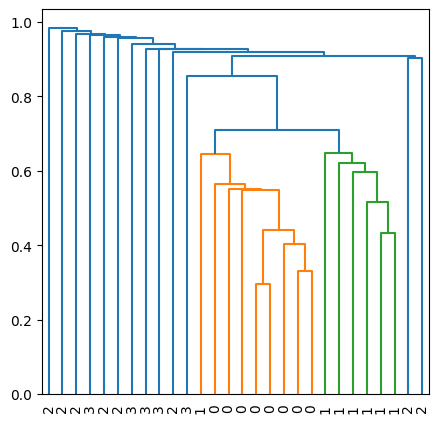

                    Method       ARI       NMI
0      Spectral Clustering  0.743642  0.807805
1  Hierarchical Clustering -0.000383  0.165709


In [7]:
from sklearn.cluster import SpectralClustering
from sklearn.metrics import adjusted_rand_score, normalized_mutual_info_score
from scipy.cluster.hierarchy import linkage, fcluster, dendrogram
from scipy.spatial.distance import squareform
import pandas as pd

ts_names = gt

Cs = []
Zs = []
single = 4
n_clust = 4


for k in [n_clust]:
    spectral = SpectralClustering(n_clusters=k, affinity='precomputed')
    clusters = spectral.fit_predict(S)
    Cs.append(clusters)
    Z = linkage(squareform(D), method='single')
    h = fcluster(Z, k, criterion='maxclust')
    Zs.append(h)
    fig, ax = plt.subplots(figsize=(5, 5))
    dendrogram(Z, labels=ts_names, ax=ax, leaf_rotation=90)
    plt.show()

df = pd.DataFrame({'Label': ts_names})
for i, k in enumerate([n_clust]):
    df[f'Spectral {k}'] = Cs[i]
    df[f'Hierarchical {k}'] = Zs[i]

df.set_index('Label', inplace=True)
#print(df)

ari2 = adjusted_rand_score(gt, Cs[0])
ari3 = adjusted_rand_score(gt, Zs[0])
nmi2 = normalized_mutual_info_score(gt, Cs[0])
nmi3 = normalized_mutual_info_score(gt, Zs[0])
df_metrics = pd.DataFrame({
    'Method': ['Spectral Clustering', 'Hierarchical Clustering'],
    'ARI': [ari2, ari3],
    'NMI': [nmi2, nmi3]
})
print(df_metrics)

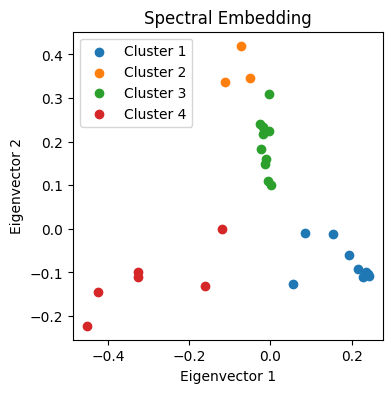

In [8]:
from scipy.linalg import eigh
from scipy.sparse.csgraph import laplacian
L = laplacian(S, normed=True)

eigenvalues, eigenvectors = eigh(L)
#embedding = eigenvectors[:, 1:3]
embedding = eigenvectors[:, 1:3]

plt.figure(figsize=(4, 4))
for i in range(n_clust):
    plt.scatter(embedding[clusters == i, 0], embedding[clusters == i, 1], label=f'Cluster {i+1}')
plt.title('Spectral Embedding')
plt.xlabel('Eigenvector 1')
plt.ylabel('Eigenvector 2')
plt.legend()
plt.show()

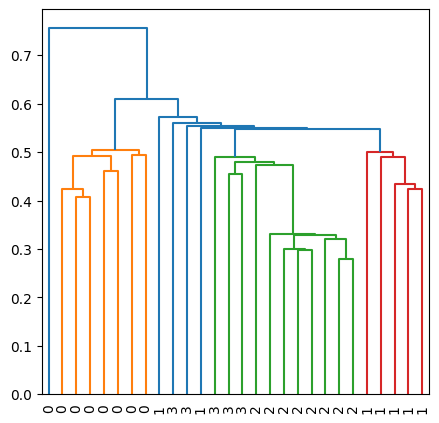

ari: 0.31276542593055207 // nmi: 0.5749301386196113


In [9]:
Z1 = linkage(squareform(ds), method='single')
h1 = fcluster(Z1, k, criterion='maxclust')
fig, ax = plt.subplots(figsize=(5, 5))
dendrogram(Z1, labels=ts_names, ax=ax, leaf_rotation=90)
plt.show()
ari4 = adjusted_rand_score(gt, h1)
nmi4 = normalized_mutual_info_score(gt, h1)
print(f'ari: {ari4} // nmi: {nmi4}')

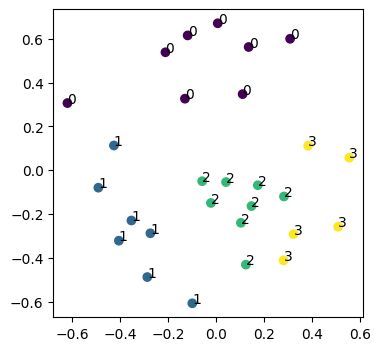

In [10]:
from sklearn.manifold import MDS

mds2 = MDS(n_components=2, dissimilarity='precomputed')
points2 = mds2.fit_transform(ds)

plt.figure(figsize=(4, 4))
scatter = plt.scatter(points2[:, 0], points2[:, 1], c=gt)
for i, label in enumerate(ts_names):
    #plt.annotate(label[1], (points2[i, 0], points2[i, 1]))
    plt.annotate(label, (points2[i, 0], points2[i, 1]))